In [ ]:
pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.8 MB 28.8 MB/s 
     |████████████████████████████████| 9.8 MB 45.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
from tbats import BATS, TBATS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np

#Loading the data

In [ ]:
df=pd.read_csv("/content/fremont-bridge.csv", index_col= 'Date', parse_dates=True)

#Data Preprocessing

In [ ]:
df_nw=df.copy()

In [ ]:
df_nw['Total']=df['East']+df['West']

In [ ]:
df_nw.drop(["West","East"],axis=1,inplace=True)

#Train-Test Split

In [ ]:
y = df_nw['Total']
y_to_train = y.iloc[:(len(y)-8760)]
y_to_test = y.iloc[(len(y)-8760):] # last year for testing


In [ ]:
y_to_test

Date
2017-01-01 00:00:00     5.0
2017-01-01 01:00:00    19.0
2017-01-01 02:00:00     1.0
2017-01-01 03:00:00     2.0
2017-01-01 04:00:00     1.0
                       ... 
2017-12-31 19:00:00    21.0
2017-12-31 20:00:00    14.0
2017-12-31 21:00:00    13.0
2017-12-31 22:00:00    13.0
2017-12-31 23:00:00    16.0
Name: Total, Length: 8760, dtype: float64

#Resampling Data (Day-Wise)

In [ ]:
y_to_train=y_to_train.resample('D').mean()

In [ ]:
y_to_test=y_to_test.resample('D').mean()

In [ ]:
y_to_test

Date
2017-01-01    13.583333
2017-01-02    25.958333
2017-01-03    72.333333
2017-01-04    75.333333
2017-01-05    74.041667
                ...    
2017-12-27    41.541667
2017-12-28    40.500000
2017-12-29    24.625000
2017-12-30    30.208333
2017-12-31    30.583333
Freq: D, Name: Total, Length: 365, dtype: float64

In [ ]:
validate= pd.DataFrame(y_to_test, columns = ['Total'])

In [ ]:
validate

,Total
Date,
2017-01-01,13.583333
2017-01-02,25.958333
2017-01-03,72.333333
2017-01-04,75.333333
2017-01-05,74.041667
...,...
2017-12-27,41.541667
2017-12-28,40.500000
2017-12-29,24.625000


#TBATS Model Fitting

In [ ]:
from tbats import TBATS, BATS # Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(y_to_train) # Forecast 365 days ahead

/usr/local/lib/python3.7/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


In [ ]:
y_forecast = model.forecast(steps=365)
y_forecast

array([ 11.46120923,  80.89365347,  91.25925232,  90.56817982,
        84.27313877,  71.19376312,  18.12558693,  16.16236629,
        85.02575916,  94.95473271,  93.93286043,  87.39155918,
        74.13342874,  20.94037044,  18.89522879,  87.71092718,
        97.61943987,  96.59874075,  90.07576182,  76.84950985,
        23.69900662,  21.70478799,  90.57792545, 100.54890673,
        99.59451169,  93.14071222,  79.98574224,  26.90800055,
        24.98751995,  93.93496488, 103.98049294, 103.10061536,
        96.72108477,  83.63995531,  30.63547771,  28.78756212,
        97.8067707 , 107.9231752 , 107.11321416, 100.80257817,
        87.78926789,  34.85148752,  33.06910627, 102.15264999,
       112.33215782, 111.5840388 , 105.33395653,  92.37988683,
        39.5000108 ,  37.77417608, 106.91288825, 117.14616726,
       116.45040397, 110.25124468,  97.34664867,  44.51478124,
        42.8354749 , 112.0192207 , 122.29602469, 121.64226436,
       115.4835732 , 102.61789821,  49.82339292,  48.17

In [ ]:
validate['Total_Forecast'] = y_forecast

In [ ]:
validate

,Total,Total_Forecast
Date,,
2017-01-01,13.583333,11.461209
2017-01-02,25.958333,80.893653
2017-01-03,72.333333,91.259252
2017-01-04,75.333333,90.568180
2017-01-05,74.041667,84.273139
...,...,...
2017-12-27,41.541667,91.619413
2017-12-28,40.500000,84.779795
2017-12-29,24.625000,71.242280


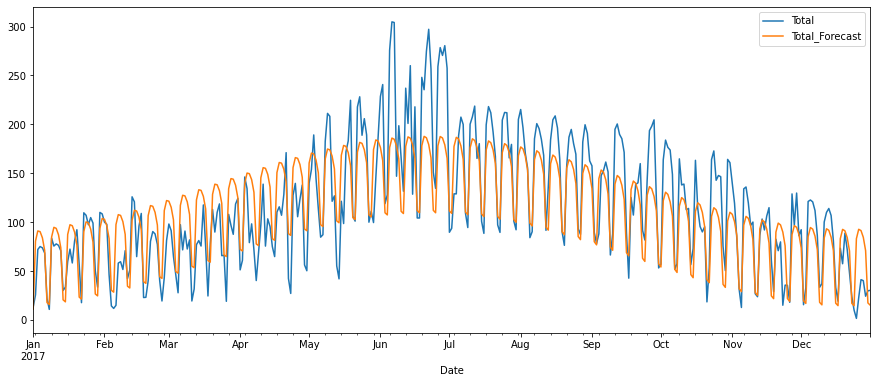

In [ ]:
validate[['Total','Total_Forecast']].plot(figsize=(15,6))

#Evaluation Metrics

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
def eval(y_true,y_predicted):
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    return mae,rmse,mape

In [ ]:
y_true=validate['Total']
y_pred=validate['Total_Forecast']
mae,rmse,mape=eval(y_true,y_pred)
print("MAE = {} ; RMSE = {} ; MAPE = {}".format(mae,rmse,mape))

MAE = 28.41897736942669 ; RMSE = 36.44484295479113 ; MAPE = 0.45606471179985936


#Prediction on Best Model

In [ ]:
model=estimator.fit(y_to_test)
y_pred=model.forecast(steps=31)

In [ ]:
actual = pd.DataFrame(y_to_test, columns = ['Total'])

In [ ]:
actual

,Total
Date,
2017-01-01,13.583333
2017-01-02,25.958333
2017-01-03,72.333333
2017-01-04,75.333333
2017-01-05,74.041667
...,...
2017-12-27,41.541667
2017-12-28,40.500000
2017-12-29,24.625000


In [ ]:
pred_new = pd.DataFrame({
        'Date' : pd.date_range(start = '2018-01-01', end = '2018-01-31').tolist(),
        'Total_Pred' : y_pred
        })

In [ ]:
pred_new.set_index('Date', inplace=True)

In [ ]:
pred_new

,Total_Pred
Date,
2018-01-01,63.315143
2018-01-02,67.963447
2018-01-03,66.896635
2018-01-04,60.418551
2018-01-05,55.671250
2018-01-06,21.949448
2018-01-07,19.075081
2018-01-08,54.853502
2018-01-09,60.412243


In [ ]:
prediction=pd.concat([actual, pred_new])

In [ ]:
prediction

,Total,Total_Pred
Date,,
2017-01-01,13.583333,NaN
2017-01-02,25.958333,NaN
2017-01-03,72.333333,NaN
2017-01-04,75.333333,NaN
2017-01-05,74.041667,NaN
...,...,...
2018-01-27,NaN,18.999005
2018-01-28,NaN,16.737669
2018-01-29,NaN,50.678181


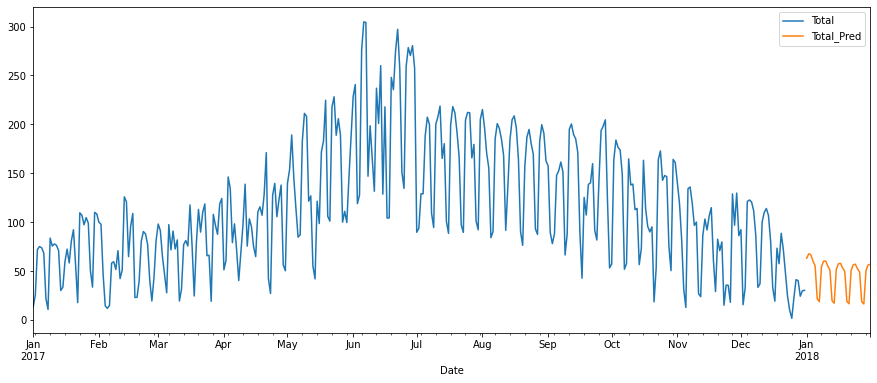

In [ ]:
prediction[['Total','Total_Pred']].plot(figsize=(15,6))